# Quantum Hall en grafeno

In [ ]:
## Importamos los módulos básicos:

import kwant #importamos kwant
import kwant.continuum #para los modelos continuos
import matplotlib.pyplot as plt #pyplot para los plots
import numpy as np #numpy para trabajar con vectores
import scipy as sp #scipy para diagonalizaciones, integraciones, etc
import sympy # importamos sympy para que las matrices se muestren mejor en el notebook
sympy.init_printing()

import tinyarray
# Definimos las matrices de Pauli:
sigma_0 = tinyarray.array([[1, 0], [0, 1]])
sigma_x = tinyarray.array([[0, 1], [1, 0]])
sigma_y = tinyarray.array([[0, -1j], [1j, 0]])
sigma_z = tinyarray.array([[1, 0], [0, -1]])

## Barras Hall: conductancia en varios terminales

Hasta este punto hemos estado calculando la conductancia $G$  sistemas de dos terminales. En cambio, un sistema con más contactos puede ser interesante para estudiar todas las implicaciones de la fórmula de Landauer-Büttiker y cómo se relacion la matriz de transmisión con la corriente en un sistem multiterminal. A temperatura cero la fórmula de Landuer-Büttiker es:

$$I_p = \sum_q G_{pq} \left[  V_p - V_q \right]~.$$
$$ G_{pq} = \frac{2 e^2}{\hbar} T_{p \rightarrow q}~,$$
donde la corriente $I_p$ se mide en el lead $p$.

Por ejemplo, para un sistema de tres terminales como en el de la figura se obtiene el siguiente sistema de ecuaciones:

\begin{equation}
    \begin{pmatrix} I_1 \\ I_2 \\ I_3
    \end{pmatrix}
    = \begin{pmatrix}
          G_{12} + G_{13} & - G_{12} & - G_{13} \\
          -G_{21} & G_{21}+ G_{23} & -G_{23} \\
          -G_{31} & - G_{32} & G_{31} + G_{32}
    \end{pmatrix}
    \begin{pmatrix}
            V_1 \\ V_2 \\ V_3
    \end{pmatrix}~.
\end{equation}

Debido a la ley de Kirchhoff, las tres ecuaciones están relacionadas por la condición $ I_1 + I_2 + I_3 = 0 $, lo que implica que una de las ecuaciones es linealmente dependiente. Esto equivale a decir que solo la **diferencia de potencial** es una cantidad física, por lo que uno de los voltajes puede fijarse como referencia.

Si se toma $ V_3 = 0 $, el sistema se reduce a:

$$
\begin{pmatrix} I_1 \\ I_2 \end{pmatrix} =
\begin{pmatrix}
G_{12} + G_{13} & -G_{12} \\
-G_{21} & G_{21} + G_{23}
\end{pmatrix}
\begin{pmatrix} V_1 \\ V_2 \end{pmatrix}
$$


Dada una corriente aplicada, la caída de potencial entre dos terminales se puede calcular invirtiendo la ecuación anterior:

$$
\begin{pmatrix} V_1 \\ V_2 \end{pmatrix}
= \begin{pmatrix}
G_{12} + G_{13} & -G_{12} \\
-G_{21} & G_{21} + G_{23}
\end{pmatrix}^{-1}
\begin{pmatrix} I_1 \\ I_2 \end{pmatrix}
=
\frac{1}{A}
\begin{pmatrix}
G_{21} + G_{23} & G_{21} \\
G_{12} & G_{12} + G_{13}
\end{pmatrix}
\begin{pmatrix} I_1 \\ I_2 \end{pmatrix}
$$

donde $ A = (G_{12} + G_{13})(G_{21} + G_{23}) - G_{12}G_{21} $ es el **determinante** de la matriz $ 2 \times 2 $ anterior.

Una vez obtenidas las caídas de voltaje, la resistencia se calcula con la expresión usual $ R = V/I $. Sin embargo, en un sistema de múltiples terminales, la resistencia depende de los índices de los terminales de inyección y recolección de corriente, así como de los terminales de medición de voltaje.

Se define entonces con cuatro índices:

$$ R_{ij;kl} = \frac{V_i - V_j}{I_k - I_l} $$

En el dispositivo de tres terminales de este ejemplo, todas las mediciones de resistencia son locales debido al número reducido de terminales.

Para calcular la resistencia correspondiente al esquema de la figura, se usa la siguiente expresión:

$$ R_{23;12} = \frac{V_2 - V_3}{I_1 - I_2} = \frac{G_{12}}{A} $$

si se cumple que $ I_2 = 0 $.



In [ ]:
def solve_multiTerminal(Tmatrix, lead0=0, I0=[0, 0, 0, 0, -1, 1], num_leads=6):
    G = Tmatrix
    G -= np.diag(np.sum(G, axis=0))

    temp = list(range(0, num_leads))
    temp.remove(lead0)

    G = G[temp, :]
    G = G[:, temp]

    # invert R = G^-1
    try:
        r = np.linalg.inv(G);
        # Solve V = R I
        V = r @ np.array([I0[i] for i in temp])
        Vout = list(V[0:lead0]) + list([0]) + list(V[lead0:])
    except np.linalg.LinAlgError:
        Vout = [i * 0 for i in range(num_leads)]
    return Vout

##  <span style="color:orange">Ejercicio 1: prueba el solucionador de las resistencias </span>



----------------------------
Recordatorio de los pasos de creación de un código básico en Kwant:

    1. Crear un sistema de enlace fuerte “vacío”.
    2. Establecer sus elementos de matriz (onsite) y acoplamientos (*hoppings*).> Esto lo haremos con el discretizado de un modelo CONTINUO
    3. Conectar los contactos *leads* (sistemas de enlace fuerte con simetría traslacional).
    4. Pasar el sistema finalizado a un solucionador (*solver*).
---------------------------

In [ ]:
lat = kwant.lattice.honeycomb(1., norbs=1)
subA, subB = lat.sublattices
def subname(site):
    return 0 if site.family==subA else 1
def qhe_hall_bar_graphene(
        Ls=[10, 10, 60, 10], W=10, w_lead=10, w_vert_lead=None,
        densImp=None, familyOnsite=False, plot=False, add_cells = 0):
    if w_vert_lead is None:
        w_vert_lead = w_lead
    L = np.sum(Ls) + w_lead * (len(Ls) - 1)

    # bar shape
    def bar(pos):
        (x, y) = pos
        return (0 <= x <= L and 0 <= y <= W)

    # Onsite and hoppings
    def onsite(site, mu, disorder):
        return - mu + disorder(site)

    def hopping_Ax(site1, site2, t, B):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -t * np.exp(-0.5j * B * (x1 + x2) * (y1 - y2))

    """ second NN:
    def hopping_Axn2(site1, site2, t2, B):
        x1, y1 = site1.pos
        x2, y2 = site2.pos
        return -t2 * np.exp(-0.5j * B * (x1 + x2) * (y1 - y2))
    """

    def make_lead_hop_y(x0):
        def hopping_Ay(site1, site2, t, B):
            x1, y1 = site1.pos
            x2, y2 = site2.pos
            return -t * np.exp(-1j * B * x0 * (y1 - y2))

        return hopping_Ay

    def lead_hop_vert(site1, site2, t):
        return -t

    lead_onsite = lambda site, mu_lead: - mu_lead

    # Building system

    sys = kwant.Builder()
    if familyOnsite == True:
        def onsiteA(site, muA):
            (x, y) = site.pos
            return - muA

        def onsiteB(site, muB):
            (x, y) = site.pos
            return - muB

        sys[subA.shape(bar, (0, 0))] = onsiteA
        sys[subB.shape(bar, (0, 0))] = onsiteB
    else:
        sys[lat.shape(bar, (0, 0))] = onsite
    sys[lat.neighbors()] = hopping_Ax
    sys.eradicate_dangling()
    # sys[lat.neighbors(n=2)] = hopping_Axn2

    if densImp != None:
        sites = list(sys.sites())
        Nsites = len(sites)
        nImp = random.sample(range(0, Nsites), int(Nsites * densImp))
        for i in range(int(Nsites * densImp)):
            del sys[sites[nImp[i]]]

    # Leads: Vertical:

    sym_lead_vertical = kwant.TranslationalSymmetry(lat.vec((-1, 2)))

    for i in range(len(Ls) - 1):
        lead_vertical = kwant.Builder(sym_lead_vertical)

        Li = sum(Ls[:i + 1]) + i * w_vert_lead

        def lead_shape_vertical(pos):
            (x, y) = pos
            return 0 <= x - Li <= w_vert_lead
        if add_cells >0:
            def sys_shape_vertical(pos):
                (x, y) = pos
                return 0 <= x - Li <= w_vert_lead and (-add_cells <= y <= W + add_cells)
            sys[lat.shape(sys_shape_vertical, (Li, 0))] = onsite
            sys[lat.neighbors()] = hopping_Ax
        lead_vertical[lat.shape(lead_shape_vertical, (+Li, W))] = lead_onsite
        lead_vertical[lat.neighbors()] = lead_hop_vert
        sys.attach_lead(lead_vertical)
        sys.attach_lead(lead_vertical.reversed())

    # Leads: Horizontal: they are numbered as 4 and 5!!
    sym_lead = kwant.TranslationalSymmetry(lat.vec((-1, 0)))
    sym_lead.add_site_family(subA, other_vectors=[
        (-1, 2)])  # other vectors es en función de la base! Este vector es [0, sqrt(3)]
    sym_lead.add_site_family(subB, other_vectors=[(-1, 2)])

    lead = kwant.Builder(sym_lead)

    def lead_shape(pos):
        (x, y) = pos
        return 0 < y <= w_lead

    lead[lat.shape(lead_shape, (-1, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(0)

    sys.attach_lead(lead)

    sym_lead = kwant.TranslationalSymmetry(lat.vec((+1, 0)))
    sym_lead.add_site_family(subA, other_vectors=[
        (-1, 2)])  # other vectors es en función de la base! Este vector es [0, sqrt(3)]
    sym_lead.add_site_family(subB, other_vectors=[(-1, 2)])
    lead = kwant.Builder(sym_lead)
    lead[lat.shape(lead_shape, (L, 0))] = lead_onsite
    lead[lat.neighbors()] = make_lead_hop_y(L)

    sys.attach_lead(lead)
    if plot:
        kwant.plot(sys, colorbar=False)
    # sys.eradicate_dangling()

    return sys


# %%
L=100; W=30;  Ls=[20, 30, 20];
syst = qhe_hall_bar_graphene(Ls = Ls, W=W, w_lead=W, w_vert_lead=W, densImp = None, plot = True, add_cells=5).finalized()

Bs = np.linspace(0, 0.31, 300)
num_leads = len(syst.leads)
sitesL = syst.sites
nsites = len(sitesL)
tagL = np.array([sitei.tag for sitei in sitesL])
xlim = [np.min(tagL[:, 0]), np.max(tagL[:, 0])]
ylim = [np.min(tagL[:, 1]), np.max(tagL[:, 1])]

# %%

en = 0.
mu0L = [0.35, 0.45, 0.55, 0.6] #[0.4, 0.5, 0.6]
nReal = 50
wAL = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45]
xLim = -1. #(np.sum(Ls) + w_lead * (len(Ls) - 1)) // 2
if calc:
    for mu0 in mu0L:
        p = dict(t=1.0, mu=mu0, mu_lead=mu0)
        systp = syst.precalculate(energy=en, leads=np.arange(num_leads - 2), params=p, )

        VHall0 = np.empty((len(Bs), num_leads))
        Tlist0 = np.empty((len(Bs), num_leads, num_leads))


        def null_func(site):
            return 0


        for i, B in enumerate(Bs):
            p.update(B=B, disorder=null_func)
            smatrix = kwant.smatrix(systp, energy=en, params=p)
            Tmatrix = [[smatrix.transmission(i, j) for i in range(num_leads)] for j in range(num_leads)]
            Tlist0[i] = Tmatrix
            VHall0[i] = (solve_multiTerminal(Tmatrix, lead0=2, I0=[0, 0, 0, 0, 1, -1], num_leads=6))
            np.savez(folder + 'Data/Transm_L{}W{}_mu{}_wA0.npz'.format(L, W, mu0), VHall=VHall0, Tlist=Tlist0)

        VHall = np.empty((nReal, len(Bs), num_leads))
        Tlist = np.empty((nReal, len(Bs), num_leads, num_leads))

        for wA in wAL:
            matrand = wA * (np.random.rand(nReal, xlim[1] - xlim[0] + 1, ylim[1] - ylim[0] + 1, 2) - 0.5)
            for n in range(nReal):
                def disorder_func(site):
                    x = site.pos[0]
                    xi, yi = site.tag
                    if x > xLim:
                        return matrand[n, xi - xlim[0], yi - ylim[0], subname(site)]
                    else:
                        return 0

                for i, B in enumerate(Bs):
                    p.update(B=B, disorder=disorder_func)
                    smatrix = kwant.smatrix(systp, energy=en, params=p)
                    Tmatrix = [[smatrix.transmission(i, j) for i in range(num_leads)] for j in range(num_leads)]
                    Tlist[n, i] = Tmatrix
                    VHall[n, i] = (solve_multiTerminal(Tmatrix, lead0=2, I0=[0, 0, 0, 0, 1, -1], num_leads=6))
                np.savez(folder + 'Data/Transm_L{}W{}_mu{}_wA{}.npz'.format(L, W, mu0, wA), VHall=VHall, Tlist=Tlist,
                         matrand=matrand)

In [2]:
## Vamos a crear

sqrt3 = 1/np.sqrt(3)
def make_aGNR(L, W):
    t = 1

    # 1) inicializamos un Builder y definimos una red
    syst = kwant.Builder()
    lat = kwant.lattice.honeycomb(a=1, norbs=1)
    subA, subB = lat.sublattices # la red hexagonal está formada por dos subredes triangulares

    # 2) rellenamos el sistema con sitios de la red

    def shapeaGNR(pos):
        x, y, = pos
        return 0 <= x <= W and 0 <= y <= L




    syst[lat.shape(shapeaGNR, (0, 0))]=0
    syst[lat.neighbors()] = -t


    # 3) Creamos el lead de contacto:
    sym_aGNR = kwant.TranslationalSymmetry(lat.vec((1, -2)))
    lead = kwant.Builder(sym_aGNR) #en este caso añadimos la simetría traslacional en -x

    def shape_lead(pos):
        x, y = pos
        return 0 <= x <= W

    lead[lat.shape(shape_lead, (0,0))] = 0
    lead[lat.neighbors()] = -t

    lead_r = lead.reversed() #usamos la función reversed para crear un lead en la dirección +x

    # 4) Pegamos los leads al sistema:
    syst.attach_lead(lead);
    syst.attach_lead(lead_r);

    # 5) finalizamos el sistema:
    syst = syst.finalized()
    return syst

/home/yuriko/anaconda3/envs/Kenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Kwant's plotting functions have
the side effect of selecting the matplotlib backend. To avoid this warning,
import matplotlib.pyplot, matplotlib.backends or call matplotlib.use().
  


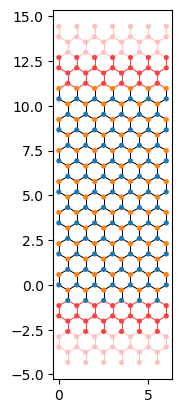

In [3]:
aGNR = make_aGNR(L = 10, W = 7*np.sqrt(3/4))
kwant.plot(aGNR);

In [4]:
## Pasos desglosados para crear el sistema:
# >>> Rellenar en clase:

## Relación de dispersión de los leads

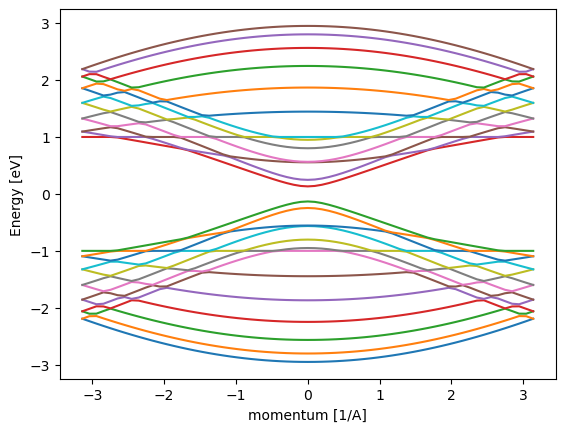

In [5]:
# Primero extraemos el lead como un sistema separado:
aLead = aGNR.leads[0];

#Obtenemos las bandas:
kwant.plotter.bands(aLead, show = False);
plt.xlabel('momentum [1/A]')
plt.ylabel('Energy [eV]')
plt.show()

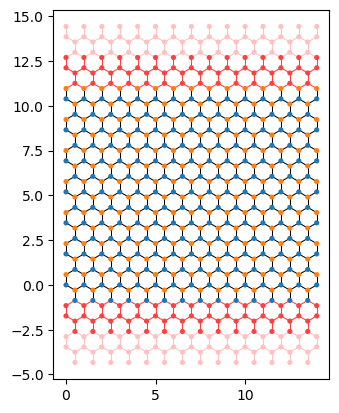

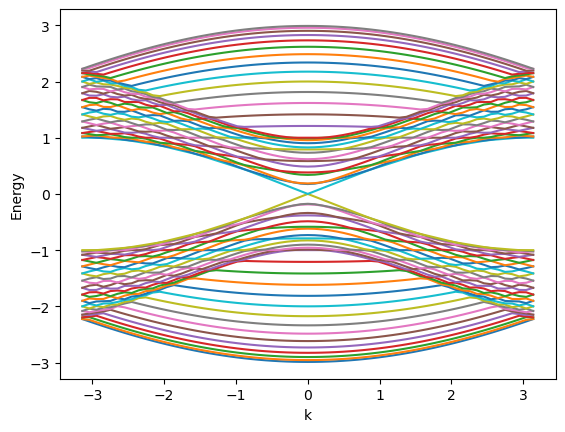

In [6]:
n_dim = 29

aGNR = make_aGNR(L=10, W=(n_dim - 1) * 0.5)
aLead = aGNR.leads[0];

kwant.plot(aGNR);
kwant.plotter.bands(aLead);

## Conductancia y funciones de onda de scattering:

A continuación calculamos la conductancia, a través de `smatrix` y las funciones de onda de scattering.


In [7]:
## CONDUCTANCIA: Desglose de los comandos en clase
# >>>


def conductance(systf, energies, params, lead_out, lead_in, plot = True):
    cond = []
    ## compute the scattering matrix for a given energy
    for energy in energies:
        smatrix = kwant.smatrix(systf, params=params, energy=energy)
        cond.append(smatrix.transmission(lead_out, lead_in))
    if plot:
        fig, ax = plt.subplots(1,1,figsize = (8,4))
        ax.plot(energies, cond);
        ax.set( ylabel=  ('Conductance [e^2/h]'), xlabel = ('Energy'))
    return np.array(cond)

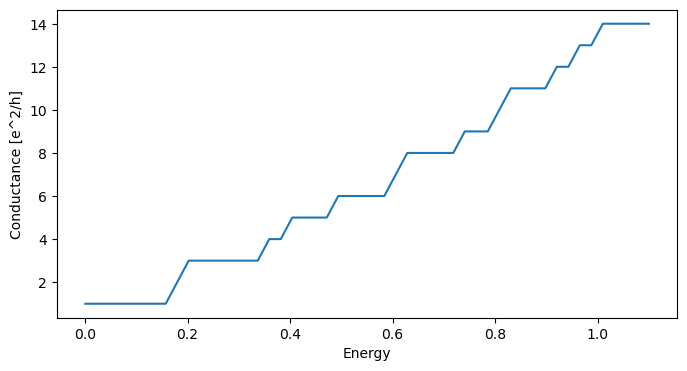

In [8]:
## Ejemplos conductancia:
energies = np.linspace(1e-4, 1.1)
cond = conductance(aGNR, energies, params = {}, lead_out = 1, lead_in = 0)

In [9]:
## DENSIDADES: desglose de los comandos en clase
# >>>

def plot_scatwf(systf, en, params):
    # Calculate the scattering states at energy 'en' coming from the left (numbered as 0) lead and right lead (lead 1)

    density = kwant.operator.Density(systf)
    fig, axs = plt.subplots(1,3,figsize=(16, 5))

    kwant.plotter.bands(systf.leads[0], params = params, ax = axs[0])
    axs[0].axhline(y = en, color= 'k', ls = '--')
    axs[0].set(title=('Bandas de los leads'),
               xlabel=('k'), ylabel=('Energy'))

    axs[1].set(title=('Scat wf from lead 0'))
    wf = kwant.wave_function(systf, energy=en, params=params)(0) #lead = 0
    psi2 = np.sum([density(wf_mode) for wf_mode in wf], axis = 0)
    kwant.plotter.density(systf, psi2, ax = axs[1], cmap = 'Purples')

    axs[2].set(title=('Scat wf from lead 1'))
    wf = kwant.wave_function(systf, energy=en, params=params)(1) #lead = 1
    psi2 = np.sum([density(wf_mode) for wf_mode in wf], axis = 0)
    kwant.plotter.density(systf, psi2, ax = axs[2], cmap = 'Purples')

    [ax.set(xlabel=('x'), ylabel=('y')) for ax in axs[1:]]
    fig.tight_layout()

    return fig


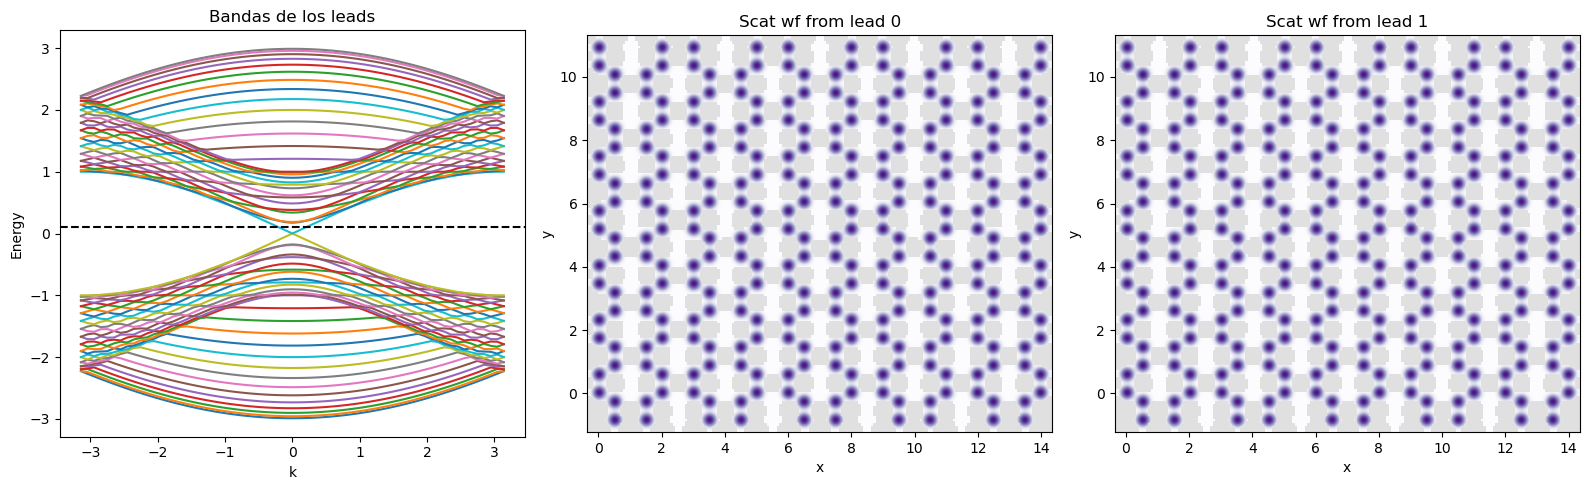

In [10]:
## Ejemplos:
en = 0.1
fig = plot_scatwf(aGNR, en, params={})

##  <span style="color:orange">Ejercicio 2: </span>
Pinta la distribución de corriente.
Modifica la función `plot_scatwf` para representar también la densidad de corriente. Para ello hay que emplear:

    kwant.plotter.current(syst, current,...);

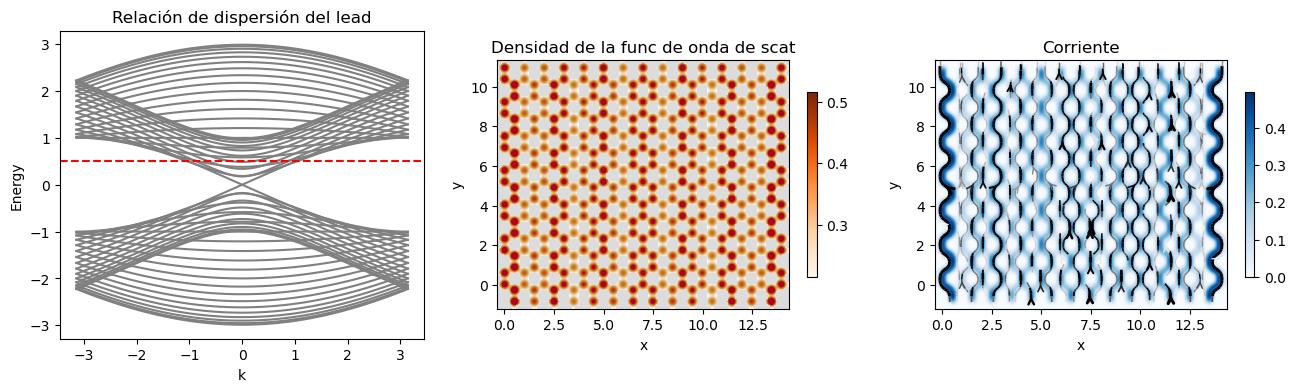

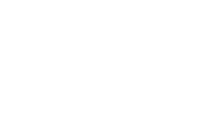

In [11]:
## Solución:

# Ahora, en vez de la conductancia, obtenemos la función de onda
# de scattering, para ver su distribución espacial

def obtain_wf(syst, energy):
    # Calculamos la función de onda del lead 0 a la energía dada
    psi = kwant.wave_function(syst, energy=energy)(0)
    # Definimos el operador corriente y densidad del systema
    rho = kwant.operator.Density(syst)
    J = kwant.operator.Current(syst)
    # Calculamos la corriente de todos los modos entrantes
    current = sum((J(p) for p in psi))
    density = sum((rho(p) for p in psi))
    # Inicializamos la figura
    fig = plt.figure(figsize=(16, 4))
    ax1 = fig.add_subplot(131);
    ax2 = fig.add_subplot(132);
    ax3 = fig.add_subplot(133);
    # Obtenemos las bandas:
    bands = kwant.physics.Bands(syst.leads[0])
    momenta = np.linspace(-np.pi, np.pi, 101)
    energies = [bands(k) for k in momenta]

    ax1.plot(momenta, energies, c='grey')
    ax1.axhline(y=energy, color='r', ls='--')
    ax1.set_title('Relación de dispersión del lead')

    # Obtenemos la densidad:
    ax2.set_title('Densidad de la func de onda de scat')
    kwant.plotter.density(syst, density, ax=ax2, vmax=0.8);

    # Obtenemos la corriente:
    ax3.set_title('Corriente')
    kwant.plotter.current(syst, current, ax=ax3, cmap='Blues');

    ax1.set_xlabel('k');
    ax1.set_ylabel('Energy')
    ax2.set_xlabel('x');
    ax2.set_ylabel('y');
    ax3.set_xlabel('x');
    ax3.set_ylabel('y');

    # Creamos unos plots ficticios para obtener fácilmente las colorbars
    fig2 = plt.figure(figsize=(2, 2));
    cmap2 = plt.imshow(np.array([[max(density),min(density)]]), cmap="Oranges")
    maxcur = np.max(kwant.plotter.interpolate_current(syst, current, )[0])
    cmap3 = plt.imshow(np.array([[maxcur,0]]), cmap="Blues")
    fig2.set_visible(False);
    fig.colorbar(cmap2, ax=ax2, shrink=0.6)
    fig.colorbar(cmap3, ax=ax3, shrink=0.6)
    [ax.set(facecolor=('gainsboro')) for ax in [ax2, ax3]]
    # [kwant.plot(syst, ax=ax, site_lw=0., site_color='grey') for ax in [ax2, ax3]]
    return fig


fig1 = obtain_wf(aGNR, energy=0.5);
# fig1.savefig('Figura.svg', transparent=True, bbox_inches='tight')


##  <span style="color:orange">Ejercicio 3: </span>

Modifica la forma de la nanocinta para incluir una constricción, o sea una nanocinta con una zona más estrecha en el centro. Puedes emplear la forma de un reloj de arena, por ejemplo.

*Pista*: Van a quedar algunos sitios desconectados. Investiga el comando `syst.eradicate_dangling()`

    def shapeaGNR(pos):
        x, y, = pos
        return abs(y) <= L/2 and abs(x) <= W1 +(L-W1)/W*np.abs(y)



# Nanocinta zigzag de grafeno
##  <span style="color:orange">Ejercicio 5: ¿Qué pasa con los zGNR? </span>

Copia el código de make_aGNR y modifícalo para crecer una cinta con borde zig zag. Para ello tienes que pensar en qué forma y qué simetría traslacional tiene que tener ahora la nanocinta.

Aquí hay alguna pista: ;)

* Empieza por obtener los vectores de la red:

        lat = kwant.lattice.honeycomb(a=1, norbs = 1)
        v1 = lat.vec((1,0)); print(v1);
        v2 = lat.vec((0,1)); print(v2);

Considerando que el grafeno tiene dos subredes, eso significa que la red está orientada así:

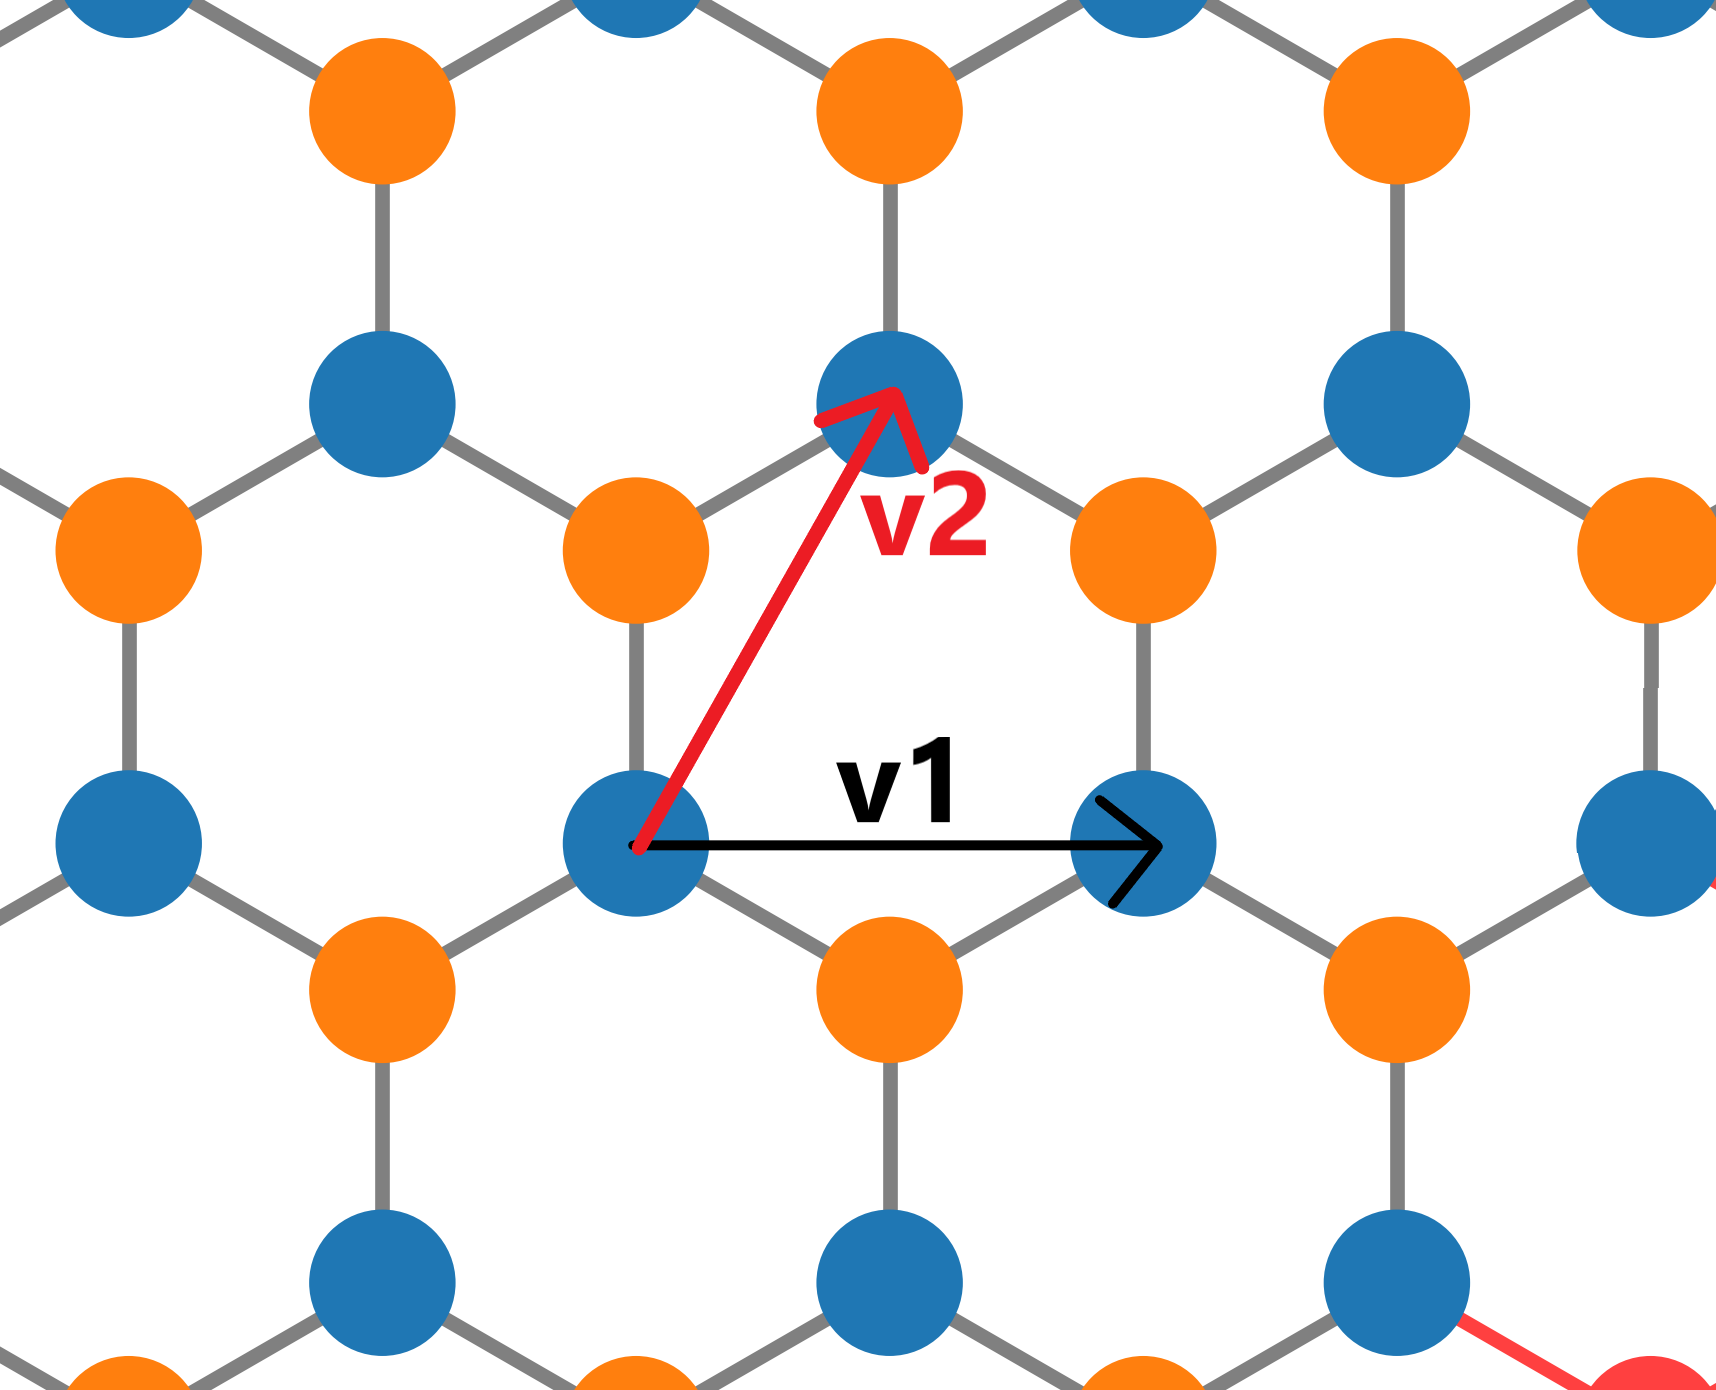


* Una nanocinta zigzag tiene que crecer con un ancho finito en la dirección "y". La simetría de los leads es en dirección, por ejemplo -x.
¿Qué vector de la red usarías para obtener un vector que sólo tenga componente x?

* Cuidado: la forma tiene que ser `-0.5 <= y <= W` para que queden hexágonos completos


Una vez construido el zGNR modifica la anchura:
* ¿Cambia el espectro?
* ¿Qué aspecto tienen los estados de scattering en este caso?

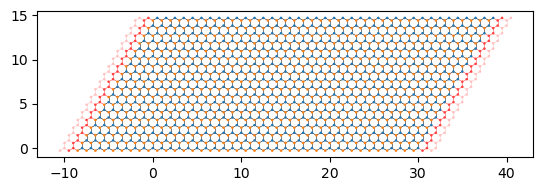

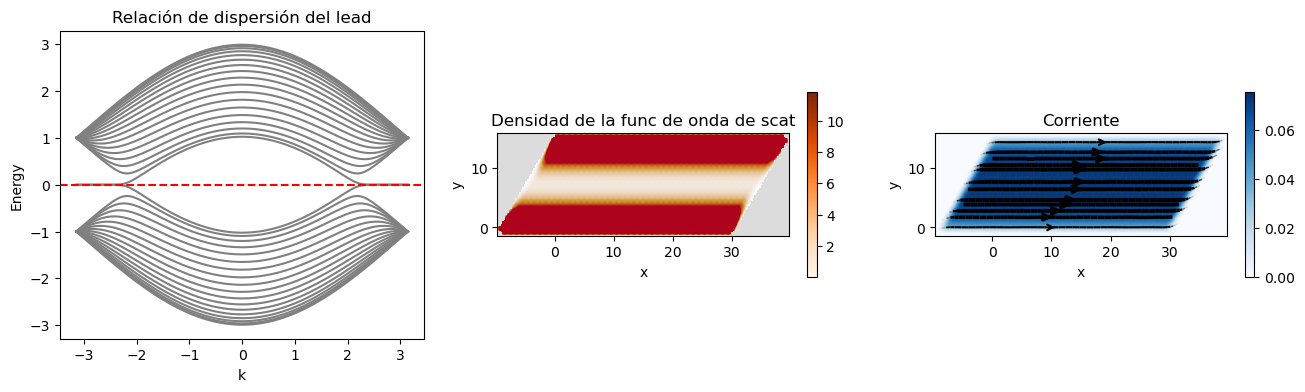

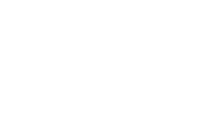

In [12]:
## Soluciones ###

def make_zGNR(L, W):
    t = 1

    # 1) inicializamos un Builder y definimos una red
    syst = kwant.Builder()
    lat = kwant.lattice.honeycomb(a=1, norbs=1)
    subA, subB = lat.sublattices  # la red hexagonal está formada por dos subredes triangulares

    # 2) rellenamos el sistema con sitios de la red

    def shapezGNR(pos):
        x, y, = pos
        return 0 <= x <= L and -0.5 <= y <= W  #hay que añadir -0.5 en la dirección y por como está definida la red

    def onsite(site):
        x, y = site.pos
        return 0

    syst[lat.shape(shapezGNR, (0, 0))] = onsite
    syst[lat.neighbors()] = -t

    # 3) Creamos el lead de contacto:
    sym_zGNR = kwant.TranslationalSymmetry(lat.vec((-1, 0)))
    lead = kwant.Builder(sym_zGNR)  #en este caso añadimos la simetría traslacional en -x

    def shape_lead(pos):
        x, y = pos
        return -0.5 <= y <= W

    lead[lat.shape(shape_lead, (0, 0))] = onsite
    lead[lat.neighbors()] = -t

    lead_r = lead.reversed()  #usamos la función reversed para crear un lead en la dirección +x

    # 4) Pegamos los leads al sistema:
    syst.attach_lead(lead);
    syst.attach_lead(lead_r);

    # 5) finalizamos el sistema:
    syst = syst.finalized()
    return syst


zGNR = make_zGNR(L=30, W=15)
kwant.plot(zGNR)
fig2 = obtain_wf(zGNR, energy=1e-3);

##  <span style="color:orange">Ejercicio 6 (Avanzado)  </span>